# Railway Infrastructure Segmentation

# Preparing the Data and Environment

The data must be unzipped and placed in the current working directory:
```
./
├── train/
│   ├── images/
│   │   ├── img_0.4150824352465.png
│   │   └── ...
│   └── masks/
│       ├── img_0.4150824352465.png
│       └── ...
└── test/
    ├── img_0.21798600425031.png
    └── ...
```
The current working directory should also contain all the files from the repository on GitHub, specifically `requirements.txt` and the directory with auxiliary modules/classes/functions `src/`.
```
./
├── src/
│   ├── data.py
│   ├── inference.py
│   ├── train.py
│   ├── visualizations.py
│   └── utils.py
└── requirements.txt
```

Install the required versions of packages

In [ ]:
!pip install -r ./requirements.txt -qqq

     |████████████████████████████████| 88 kB 7.4 MB/s 
     |████████████████████████████████| 376 kB 69.9 MB/s 
     |████████████████████████████████| 113 kB 72.7 MB/s 
     |████████████████████████████████| 16.8 MB 49.0 MB/s 
     |████████████████████████████████| 78 kB 5.5 MB/s 
     |████████████████████████████████| 3.2 MB 64.9 MB/s 
     |████████████████████████████████| 95 kB 5.4 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 


Import the necessary packages

In [ ]:
import sys
import gc
import random
from pathlib import Path
from collections import Counter
import numpy as np
import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import cv2
import albumentations as A
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import dill

Set the style for matplotlib

In [ ]:
plt.style.use('ggplot')

Load the modules

In [ ]:
from src.utils import RunningAverage, iou_coef
from src.data import SegmentationDataset, get_loaders, get_transforms
from src.train import train
from src.inference import get_batch_predictions, upscale_mask, convert_bool_mask_to_submission
from src.visualizations import visualize_augmentations

Limit the number of sources of nondeterministic behavior



In [ ]:
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

Save the location of the current working directory

In [ ]:
CWD = f'/content/'

The training and prediction will be performed on the GPU


In [ ]:
device = torch.device('cuda')

# Loading Data, Data Exploration, Visualization

Create lists of all training data, their masks, test data

In [ ]:
ROOT = Path(CWD)

train_image_path = ROOT / "train" / 'images'
train_mask_path = ROOT / "train" / 'mask'
test_image_path = ROOT / "test"

ALL_IMAGES = sorted(train_image_path.glob("*.png"))
ALL_MASKS = sorted(train_mask_path.glob("*.png"))
ALL_TEST_IMAGES = sorted(test_image_path.glob("*.png"))

Check the distribution of image resolutions in the training dataset

In [ ]:
train_shapes = Counter()

for path in ALL_MASKS:
    image = Image.open(str(path))
    train_shapes[image.size] += 1

train_shapes

Counter({(2688, 1512): 5582, (1920, 1080): 2604, (3840, 2160): 17})

Check the distribution of image resolutions in the test dataset

In [ ]:
test_shapes = Counter()

for path in ALL_TEST_IMAGES:
    image = Image.open(str(path))
    test_shapes[image.size] += 1

test_shapes

Counter({(2688, 1512): 474, (3840, 2160): 526})

Check the aspect ratio in the images

In [ ]:
shapes = np.array(list(train_shapes.keys()))
np.unique(shapes.T[0] / shapes.T[1])

array([1.77777778])

Check the average image mask in the training dataset

In [ ]:
avg_mask_path = Path(f'{CWD}images/avg_mask.png')

if avg_mask_path.is_file():
    avg_mask = cv2.imread(str(avg_mask_path))
else:
    avg_mask = np.zeros((1512, 2688, 3))

    for path in tqdm(ALL_MASKS):
        mask = cv2.imread(str(path))
        mask[:, :, 0] = mask[:, :, 0] == 6
        mask[:, :, 1] = mask[:, :, 1] == 7    
        mask[:, :, 2] = mask[:, :, 2] == 10
        mask = mask.astype('float32')
        mask = cv2.resize(mask, (2688, 1512), cv2.INTER_NEAREST_EXACT)
        avg_mask += mask

    avg_mask /= len(ALL_MASKS)

    Path(f'{CWD}images').mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(avg_mask_path), avg_mask * 255.)

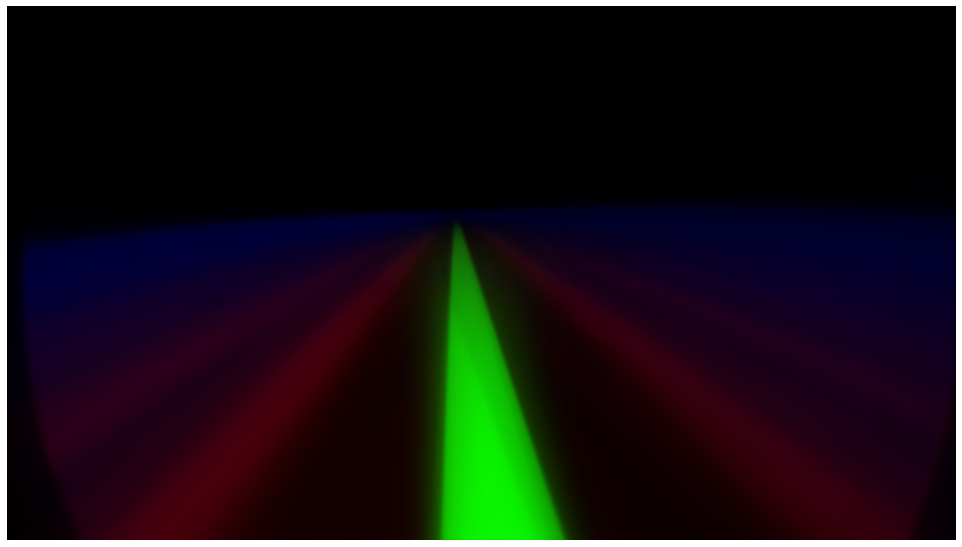

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(avg_mask);

In this picture we can see the probabilities of objects appearing in some part of the image and we can see some regularities. Let's also see if there are areas where objects never appear at all


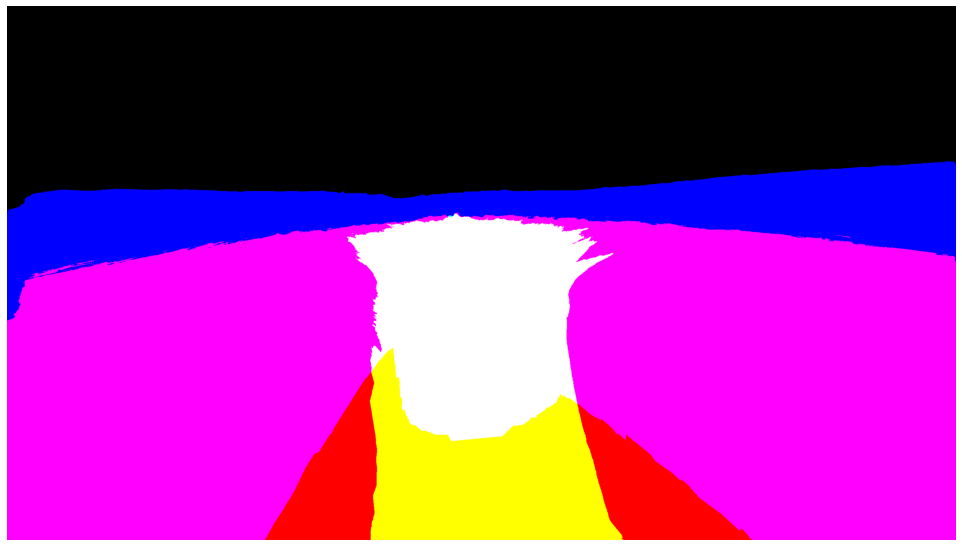

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow((avg_mask != 0).astype('float32'));

Check some dataset images and their corresponding masks

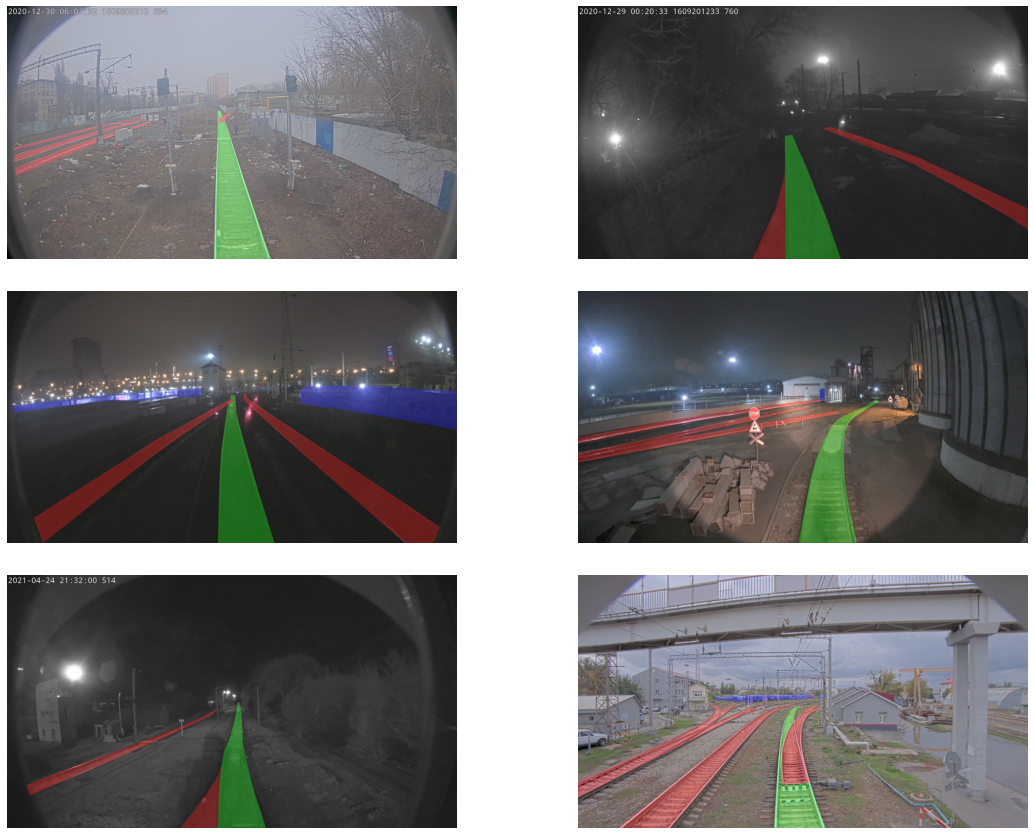

In [ ]:
ids = np.random.choice(len(ALL_IMAGES) - 1, 6, replace=False)

images = []

for id in ids:
    image = cv2.imread(str(ALL_IMAGES[id]))
    image = image.astype('float32')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image /= 255.

    mask = cv2.imread(str(ALL_MASKS[id]))
    mask[:, :, 0] = mask[:, :, 0] == 6
    mask[:, :, 1] = mask[:, :, 1] == 7
    mask[:, :, 2] = mask[:, :, 2] == 10
    mask = mask.astype('float32')

    blend = np.clip(image + mask * .3, 0, 1)
    images.append(blend)

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(16, 12))
fig.tight_layout()

for i in range(3):
    for j in range(2):
        ax[i][j].imshow(images[2 * i + j])
        ax[i][j].set_axis_off()

In [ ]:
del ids, images, fig, ax, train_shapes, test_shapes, shapes, image
del avg_mask, avg_mask_path
gc.collect()

15615

# Augmentations

For better regularization we will use various image augmentations in model training

**CoarseDropout** -  cutting out rectangular areas in the image

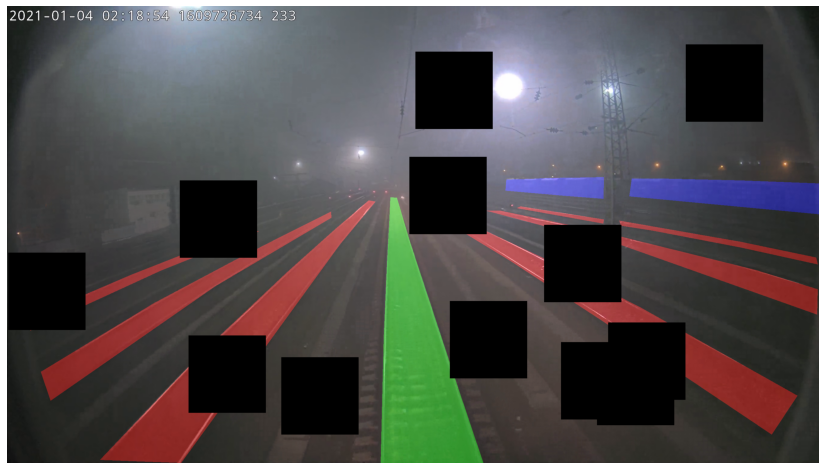

In [ ]:
image_path = str(ALL_IMAGES[100])
mask_path = str(ALL_MASKS[100])

transforms = A.Compose([A.CoarseDropout(max_holes=12,
                                        max_height=256,
                                        max_width=256,
                                        min_holes=12,
                                        min_height=256,
                                        min_width=256,
                                        fill_value=0,
                                        mask_fill_value=0,
                                        p=1)])

image = visualize_augmentations(image_path, mask_path, transforms)

fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(image);

**Perspective** - random transformation of input data in a four-point perspective

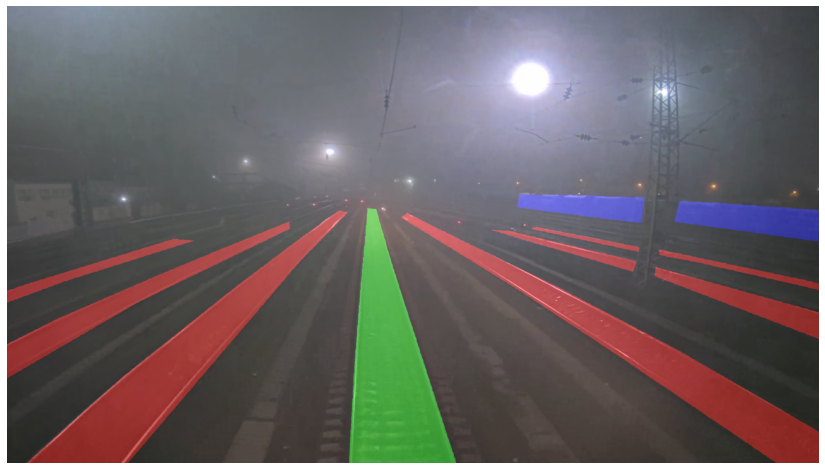

In [ ]:
transforms = A.Compose([A.Perspective(scale=(0.1, 0.1), p=1)])

image = visualize_augmentations(image_path, mask_path, transforms)

fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(image);

**HorizontalFlip** - reflection of input data horizontally around the y-axis

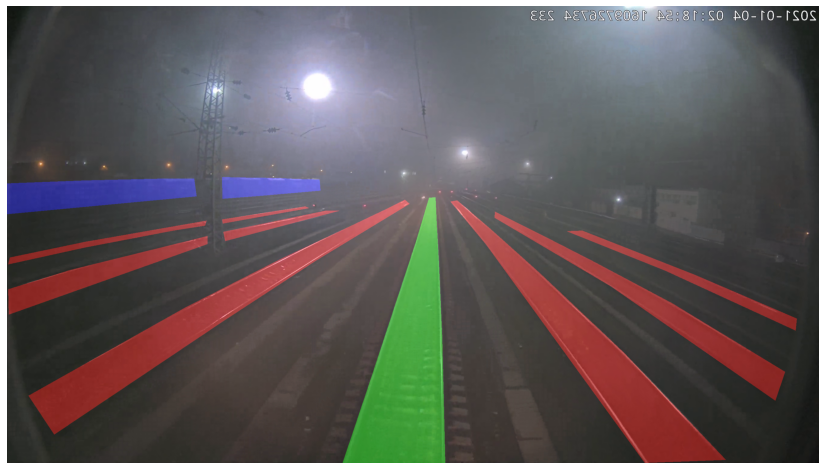

In [ ]:
transforms = A.Compose([A.HorizontalFlip(p=1)])

image = visualize_augmentations(image_path, mask_path, transforms)

fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(image);

**RandomBrightnessContrast** - randomly changing brightness and contrast

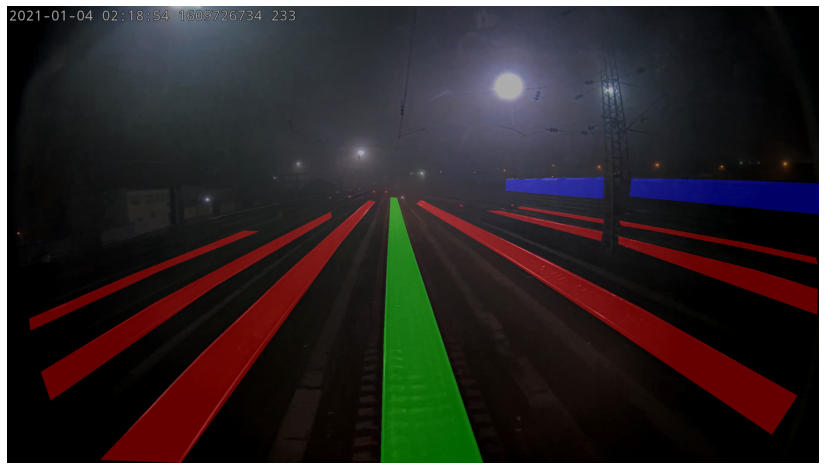

In [ ]:
transforms = A.Compose([A.RandomBrightnessContrast(brightness_limit=(-0.25),
                                                   contrast_limit=(0.25),
                                                   p=1)])

image = visualize_augmentations(image_path, mask_path, transforms)

fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(image);

**MultiplicativeNoise** - multiplication of the image by a random number or array of numbers

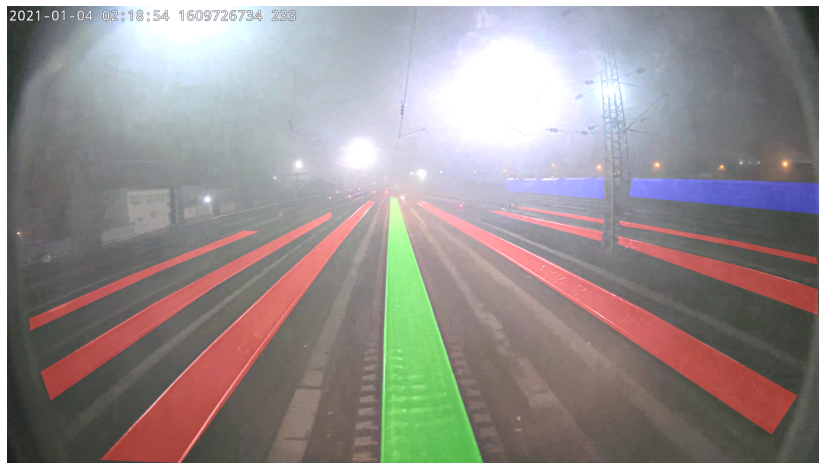

In [ ]:
transforms = A.Compose([A.MultiplicativeNoise(multiplier=(1.75, 1.75),
                                              per_channel=True,
                                              p=1)])

image = visualize_augmentations(image_path, mask_path, transforms)

fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(image);

Each augmentation uses a certain probability of its application - let's see how they would look in combination on our data

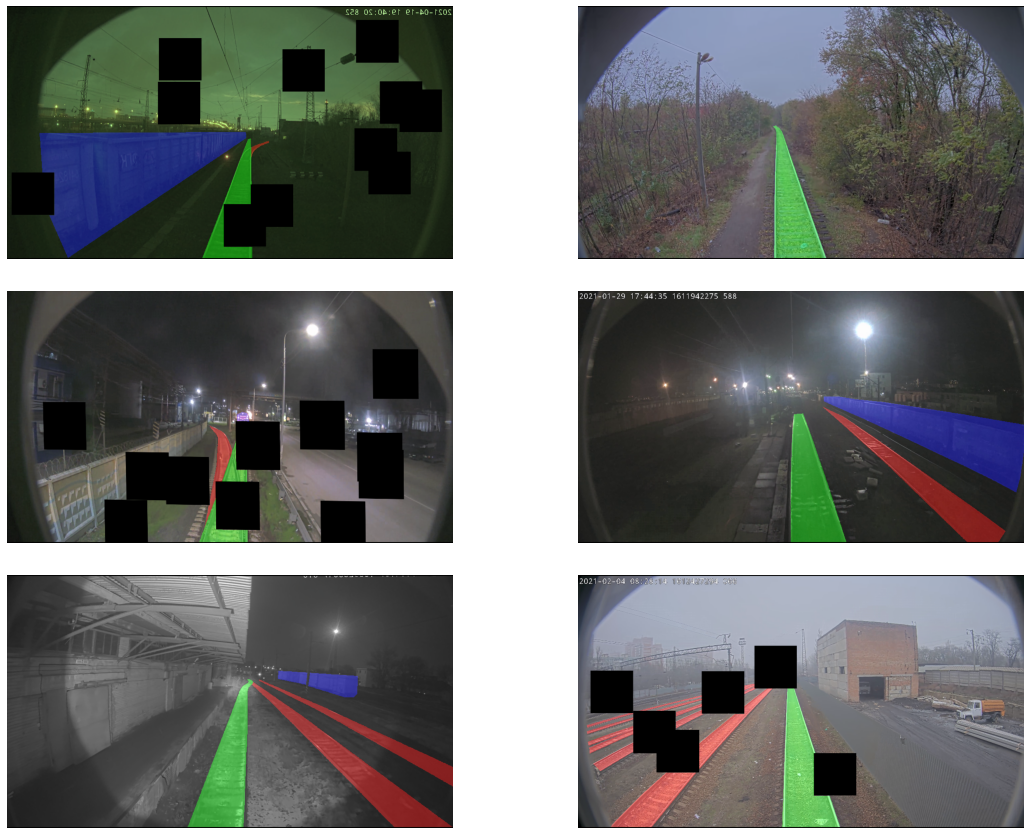

In [ ]:
vis_dataset = SegmentationDataset(images = ALL_IMAGES[:6],
                                  masks = ALL_MASKS[:6],
                                  transforms = get_transforms(add_augmentations = True))
vis_loader = DataLoader(vis_dataset, batch_size=1)

images = []
for batch in iter(vis_loader):
    image = batch['image'][0]
    mask = batch['mask'][0]

    image = image.permute(1, 2, 0)
    mask = mask.permute(1, 2, 0)

    image = image * torch.tensor([0.229, 0.224, 0.225])
    image = image + torch.tensor([0.485, 0.456, 0.406])

    blend = np.clip(image + mask * 0.4, 0, 1)
    images.append(blend)

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(16, 12))
fig.tight_layout()

for i in range(3):
    for j in range(2):
        ax[i][j].imshow(images[2 * i + j])
        ax[i][j].set_axis_off()

# Training

Let's define the previously specified augmentations

In [ ]:
transforms_train = get_transforms(image_width = 960, image_height = 544, add_augmentations = True)
transforms_test = get_transforms(image_width = 960, image_height = 544, add_augmentations = False)

Let's create data loaders for the training and validation sets. We will train all models on the same subsets to be able to validate the ensemble. We will use 95% of the data for training and 5% for validation

In [ ]:
loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state = SEED,
    train_transforms_fn=transforms_train,
    valid_transforms_fn=transforms_test,
    batch_size=8,
    num_workers = 2,
    k_folds = 20,
    current_fold = 0
)

Let's start the training. We will apply gradient accumulation and gradient clipping on the norm to train each model

## Pyramid Attention Network, EfficientNet
Let's train a model consisting of a Pyramid Attention Network decoder and an EfficientNet B4 encoder pre-trained on Imagenet using Noisy Student

In [ ]:
!mkdir -p {CWD}weights/
weights_path = f'{CWD}weights/efficientnetb4.pth.tar'
history_path = f'{CWD}weights/history_efficientnetb4'

if Path(weights_path).is_file() and Path(history_path).is_file():
    print('Skipping training - loading the weights')
    with open(history_path, 'rb') as handle:
        history = dill.load(handle)
else:
    print('Starting training')
    model = smp.PAN(encoder_name="tu-tf_efficientnet_b4_ns", encoder_weights='noisy-student', in_channels=3, classes=3)
    criterion = smp.losses.JaccardLoss(mode='multilabel')
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.000001, last_epoch=-1)
    history = train(model, optimizer, criterion, loaders['train'], loaders['val'], 25, lr_scheduler, weights_path, accumulate_every_n_epochs=2, clip_gradient = True)
    with open(history_path, 'wb') as handle:
        dill.dump(history_path, handle, protocol=dill.HIGHEST_PROTOCOL)

Skipping training - loading the weights


Plot the training stats history

In [ ]:
x = list(range(1, 26))
train_loss = [e.train_loss for e in history]
val_loss = [e.val_loss for e in history]
val_jac = [e.val_jac for e in history]

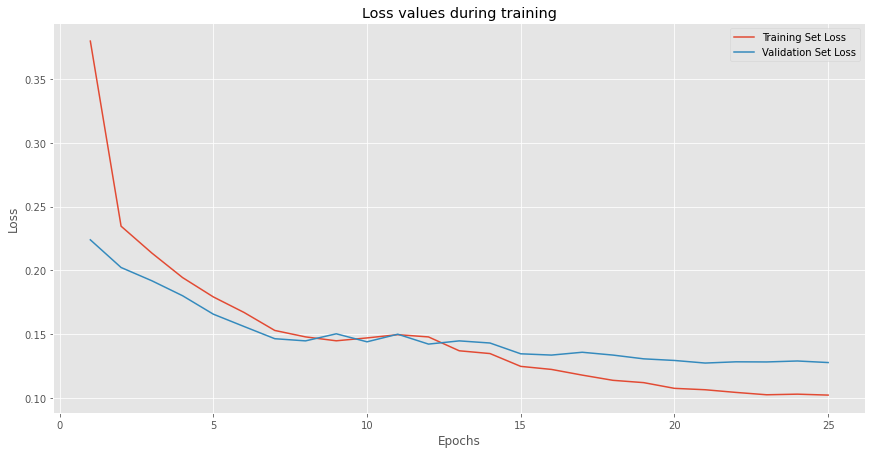

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, train_loss, label = f'Training Set Loss')
ax.plot(x, val_loss, label = f'Validation Set Loss')
ax.set_title(f'Loss values during training')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

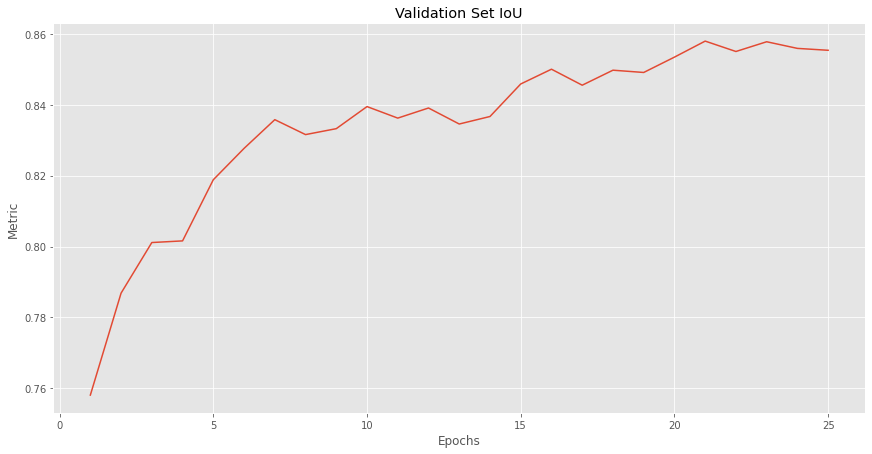

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, val_jac, label = f'IoU')
ax.set_title(f'Validation Set IoU')
ax.set_xlabel('Epochs')
ax.set_ylabel('Metric');

## Pyramid Attention Network, Nfnet
Train a model consisting of a Pyramid Attention Network decoder and a modified NFNet (Normalization Free Net) encoder using ECA (Efficient Channel Attention) and SiLU activation function. The encoder is pre-trained on Imagenet

In [ ]:
!mkdir -p {CWD}weights/
weights_path = f'{CWD}weights/eca_nfnet_l2.pth.tar'
history_path = f'{CWD}weights/history_eca_nfnet_l2'

if Path(weights_path).is_file() and Path(history_path).is_file():
    print('Skipping training - loading the weights')
    with open(history_path, 'rb') as handle:
        history = dill.load(handle)
else:
    print('Starting training')
    model = smp.PAN(encoder_name="tu-eca_nfnet_l2", encoder_weights='imagenet', in_channels=3, classes=3)
    criterion = smp.losses.JaccardLoss(mode='multilabel')
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.000001, last_epoch=-1)
    history = train(model, optimizer, criterion, loaders['train'], loaders['val'], 25, lr_scheduler, weights_path, accumulate_every_n_epochs=2, clip_gradient = True)
    with open(history_path, 'wb') as handle:
        dill.dump(history_path, handle, protocol=dill.HIGHEST_PROTOCOL)

Skipping training - loading the weights


Plot the training stats history

In [ ]:
x = list(range(1, 26))
train_loss = [e.train_loss for e in history]
val_loss = [e.val_loss for e in history]
val_jac = [e.val_jac for e in history]

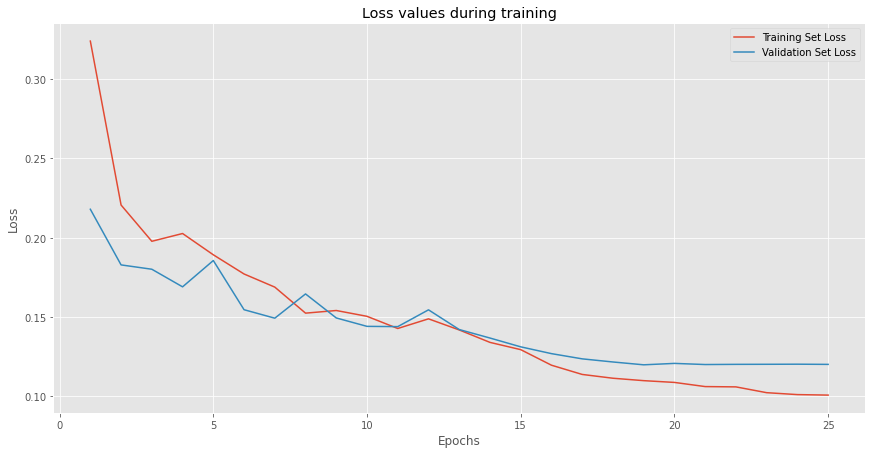

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, train_loss, label = f'Training Set Loss')
ax.plot(x, val_loss, label = f'Validation Set Loss')
ax.set_title(f'Loss values during training')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

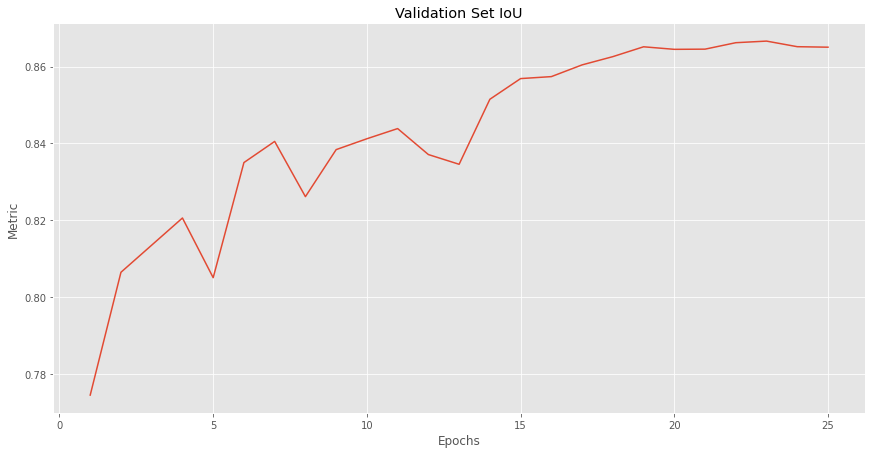

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, val_jac, label = f'IoU')
ax.set_title(f'Validation Set IoU')
ax.set_xlabel('Epochs')
ax.set_ylabel('Metric');

## Pyramid Attention Network, SE-ResNet
Let's train a model consisting of a Pyramid Attention Network decoder and a SE-ResNet encoder pre-trained on Imagenet. SE-ResNet is a variant of ResNet that uses squeeze-and-excitation blocks to allow the network to dynamically recalibrate features across channels

In [ ]:
!mkdir -p {CWD}weights/
weights_path = f'{CWD}weights/seresnet152d.pth.tar'
history_path = f'{CWD}weights/history_seresnet152d'

if Path(weights_path).is_file() and Path(history_path).is_file():
    print('Skipping training - loading the weights')
    with open(history_path, 'rb') as handle:
        history = dill.load(handle)
else:
    print('Starting training')
    model = smp.PAN(encoder_name="tu-seresnet152d", encoder_weights='imagenet', in_channels=3, classes=3)
    criterion = smp.losses.JaccardLoss(mode='multilabel')
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0.000001, last_epoch=-1)
    history = train(model, optimizer, criterion, loaders['train'], loaders['val'], 30, lr_scheduler, weights_path, accumulate_every_n_epochs=2, clip_gradient = True)
    with open(history_path, 'wb') as handle:
        dill.dump(history_path, handle, protocol=dill.HIGHEST_PROTOCOL)

Skipping training - loading the weights


Plot the training stats history

In [ ]:
x = list(range(1, 31))
train_loss = [e.train_loss for e in history]
val_loss = [e.val_loss for e in history]
val_jac = [e.val_jac for e in history]

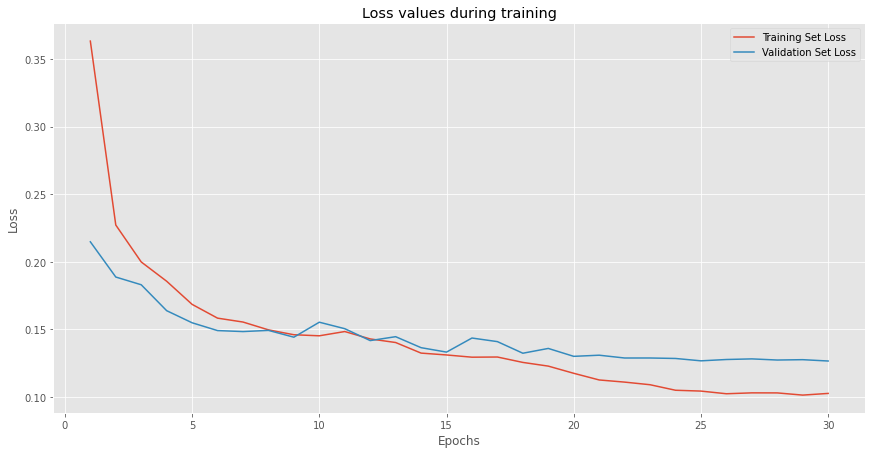

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, train_loss, label = f'Training Set Loss')
ax.plot(x, val_loss, label = f'Validation Set Loss')
ax.set_title(f'Loss values during training')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

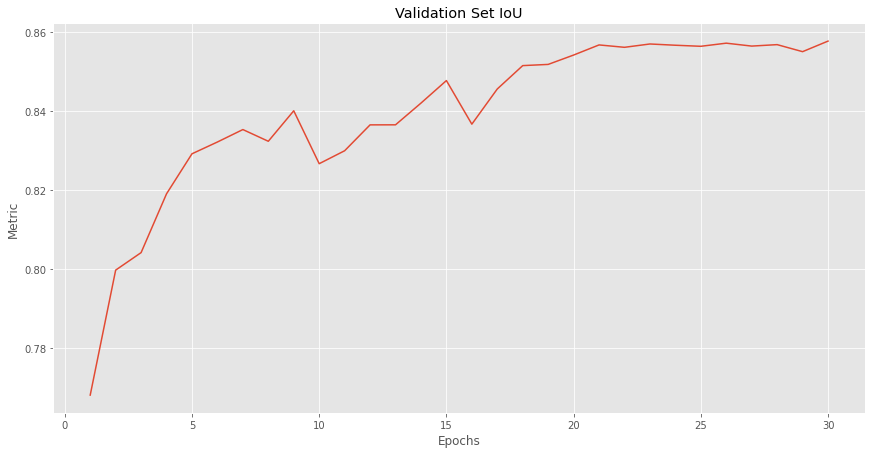

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, val_jac, label = f'IoU')
ax.set_title(f'Validation Set IoU')
ax.set_xlabel('Epochs')
ax.set_ylabel('Metric');

# Ensemble modeling

Let's build a combination of models that will allow us to get more efficient and accurate predictions

```
+----------------------+
| PAN, EfficientNet B4 +------+
+----------------------+      |
                              |     +--------------------+
+----------------------+      |     |     Ensemble:      |      +--------------+
| PAN, ECA NFNet L2    +----------->+  Weighted average  +----->+  Prediction  |
+----------------------+      |     |  for each feature  |      +--------------+
                              |     +--------------------+
+----------------------+      |
| PAN, SE-ResNet 152d  +------+
+----------------------+

```



Load the best weights

In [ ]:
models_efficientnet = [torch.load(f'{CWD}weights/efficientnetb4.pth.tar')]
models_nfnet = [torch.load(f'{CWD}weights/eca_nfnet_l2.pth.tar')]
models_resnet = [torch.load(f'{CWD}weights/seresnet152d.pth.tar')]

Define the deferred validation data to test the model ensemble

In [ ]:
indices = np.arange(len(ALL_IMAGES))
skf = KFold(20, shuffle=True, random_state=0)
splits = list(skf.split(indices))
id_train, id_val = splits[0]
val_data = SegmentationDataset(images = np.array(ALL_IMAGES)[id_val], masks = np.array(ALL_MASKS)[id_val], transforms = None)

In [ ]:
transforms_960x544 = get_transforms(image_width = 960, image_height = 544, add_augmentations = False)

Create dicts with model predictions and real masks


In [ ]:
predictions_efficientnet = {}
predictions_nfnet = {}
predictions_resnet = {}
masks_true = {}

for batch_data in tqdm(val_data):
    image = batch_data['image']
    mask = batch_data['mask']
    filename = batch_data['filename']

    transformed_img_mask_960x544 = transforms_960x544(image=image, mask = mask)
    image_960x544 = transformed_img_mask_960x544['image'].unsqueeze(0)
    mask_true_960x544 = transformed_img_mask_960x544['mask'].permute(2, 0, 1).unsqueeze(0).to(device)

    predictions_efficientnet[filename] = get_batch_predictions(models_efficientnet, image_960x544, device)
    predictions_nfnet[filename] = get_batch_predictions(models_nfnet, image_960x544, device)
    predictions_resnet[filename] = get_batch_predictions(models_resnet, image_960x544, device)
    masks_true[filename] = mask_true_960x544

100%|██████████| 411/411 [03:08<00:00,  2.18it/s]


Let's choose coefficients for the best combination of our models. Since we have several objects, the models may show different accuracy and efficiency for each object, so we will choose coefficients for each object separately

In [ ]:
for channel in range(3):
    best_val_jac = 0.0
    best_alpha = 0.0
    best_beta = 0.0
    best_gamma = 0.0

    with tqdm(total = 99 ** 2, leave=False, file=sys.stdout) as t:
        for alpha in np.arange(0.01, 1.00, 0.01):
            for beta in np.arange(0.01, 1.00, 0.01):
                val_jac_avg = RunningAverage()

                for key, y_true in masks_true.items():
                    y_pred = alpha * predictions_efficientnet[key] \
                            + beta * predictions_nfnet[key] \
                            + (1 - alpha - beta) * predictions_resnet[key]
                    jac = iou_coef(y_true[:, channel, :, :].unsqueeze(0), y_pred[:, channel, :, :].unsqueeze(0))
                    val_jac_avg.update(jac.item())
                
                if val_jac_avg() > best_val_jac:
                    best_alpha = alpha
                    best_beta = beta
                    best_gamma = 1 - alpha - beta
                    best_val_jac = val_jac_avg()
                
                t.update()

    print(f'Best coefficients for object {channel}: '
          f'alpha {best_alpha:.2f}, beta {best_beta:.2f}, gamma {best_gamma:.2f} '
          f'with object IoU: {best_val_jac:.4f}')

In [ ]:
del predictions_efficientnet, predictions_nfnet, predictions_resnet, masks_true
gc.collect()
torch.cuda.empty_cache()

# Inference

We have decided on the final architecture - let's infer the predictions on the test dataset of the competition

In [ ]:
test_data = SegmentationDataset(images = ALL_TEST_IMAGES, masks = None, transforms = None)

In [ ]:
!mkdir -p {CWD}submission/

Load the model weights

In [ ]:
models_efficientnet = [torch.load(f'{CWD}weights/efficientnetb4.pth.tar')]
models_nfnet = [torch.load(f'{CWD}weights/eca_nfnet_l2.pth.tar')]
models_resnet = [torch.load(f'{CWD}weights/seresnet152d.pth.tar')]

In [ ]:
transforms_960x544 = get_transforms(image_width = 960, image_height = 544, add_augmentations = False)

Predict and save the results to disk

In [ ]:
for batch_data in tqdm(test_data):
    image = batch_data['image']
    filename = batch_data['filename']
    original_width, original_height = batch_data['original_width'], batch_data['original_height']

    image_960x544 = transforms_960x544(image=image)['image'].unsqueeze(0)
    output_efficientnet = get_batch_predictions(models_efficientnet, image_960x544, device)
    output_nfnet = get_batch_predictions(models_nfnet, image_960x544, device)
    output_resnet = get_batch_predictions(models_resnet, image_960x544, device)
    
    coeff_efficientnet = torch.tensor([[[[0.41]],[[0.15]],[[0.11]]]]).to(device)
    coeff_nfnet = torch.tensor([[[[0.50]],[[0.44]],[[0.5]]]]).to(device)
    coeff_resnet = torch.tensor([[[[0.09]],[[0.41]],[[0.39]]]]).to(device)

    mask_pred = coeff_efficientnet * output_efficientnet \
                + coeff_nfnet * output_nfnet \
                + coeff_resnet * output_resnet

    mask_pred = mask_pred.squeeze(0).permute(1, 2, 0).cpu().numpy()
    mask_pred = upscale_mask(mask_pred, original_height, original_width)
    mask = convert_bool_mask_to_submission(mask_pred, threshold=0.5)
    cv2.imwrite(f'{CWD}submission/{filename}', mask)

100%|██████████| 1000/1000 [12:56<00:00,  1.29it/s]


Create an archive with predictions

In [ ]:
!zip -FSrj submission.zip submission > /dev/null

Let's check what our model predicts on the previously unseen test data

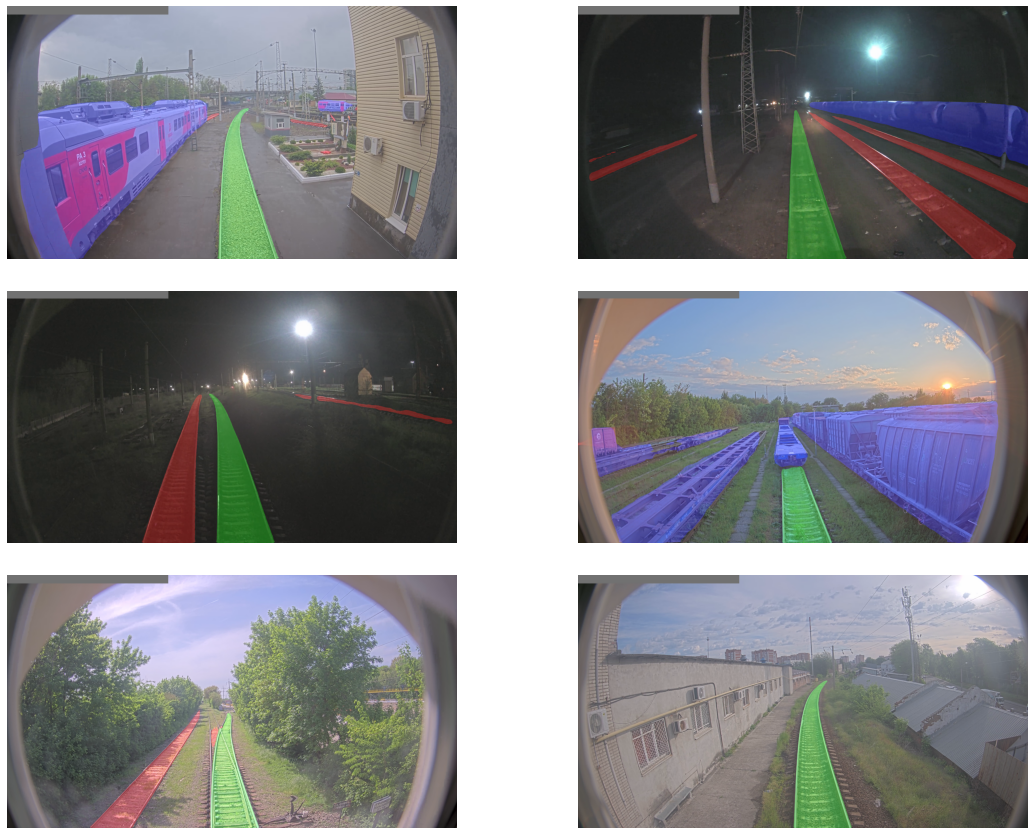

In [ ]:
ids = np.random.choice(len(ALL_TEST_IMAGES) - 1, 6, replace=False)

images = []

for id in ids:
    image = cv2.imread(str(ALL_TEST_IMAGES[id]))
    image = image.astype('float32')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image /= 255.

    mask = cv2.imread(f'{CWD}/submission/{ALL_TEST_IMAGES[id].name}')
    mask[:, :, 0] = mask[:, :, 0] == 6
    mask[:, :, 1] = mask[:, :, 1] == 7
    mask[:, :, 2] = mask[:, :, 2] == 10
    mask = mask.astype('float32')

    blend = np.clip(image + mask * .3, 0, 1)
    images.append(blend)

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(16, 12))
fig.tight_layout()

for i in range(3):
    for j in range(2):
        ax[i][j].imshow(images[2 * i + j])
        ax[i][j].set_axis_off()